In [123]:
#Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import os
import seaborn as sns # used for plot interactive graph.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import sklearn.metrics.cluster as smc
from sklearn.model_selection import KFold


from matplotlib import pyplot
import itertools

%matplotlib inline

import random 
  


# 1. Basic Statistics

In [124]:
#Read in data
hd = pd.read_csv('healthcare-dataset-stroke-data.csv')
hd.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [125]:
hd.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [126]:
hd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [201]:
hd['bmi'].mean()

28.862035225049

In [202]:
hd['bmi'].median()

28.1

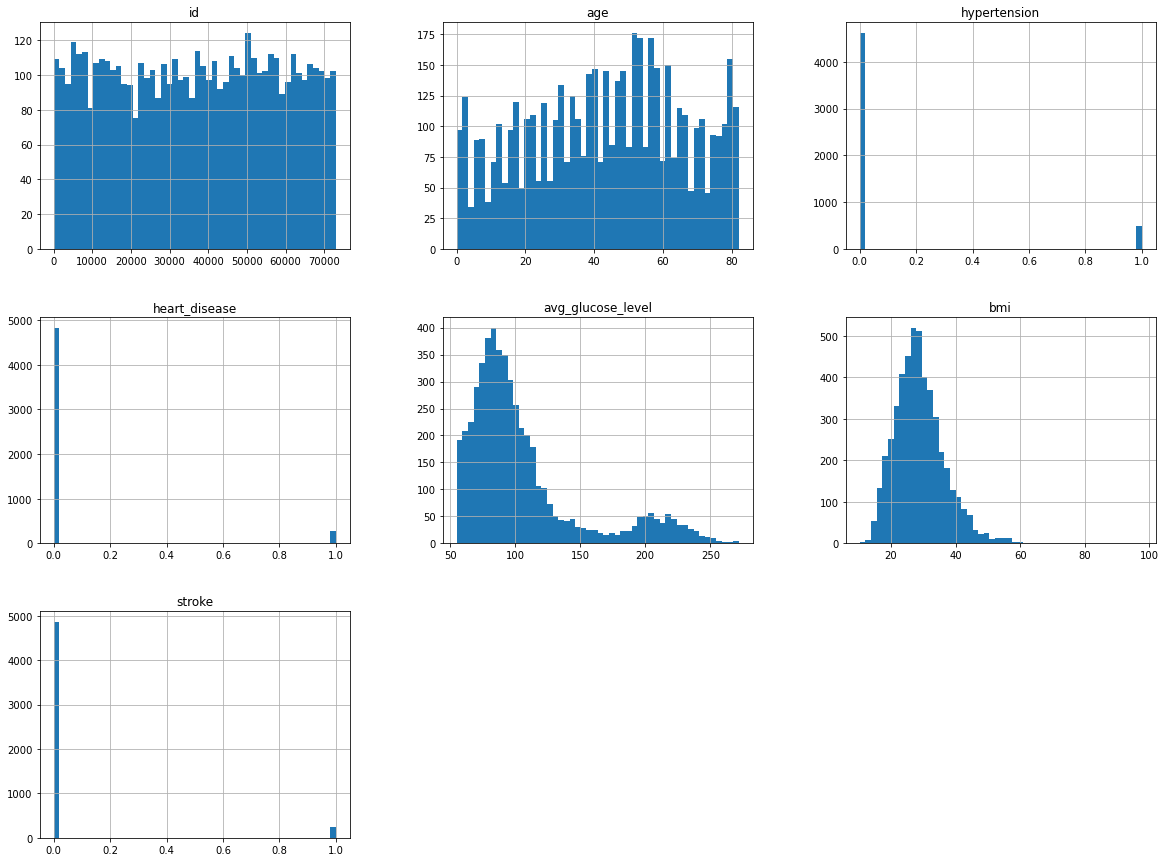

In [127]:
hd.hist(bins=50, figsize=(20,15))
plt.show()

0    4861
1     249
Name: stroke, dtype: int64

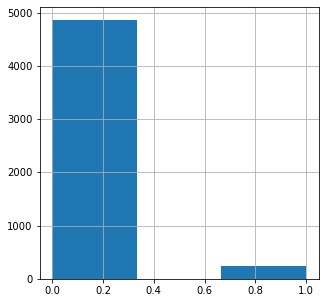

In [128]:
hd['stroke'].hist(bins=3, figsize=(5,5))
hd['stroke'].value_counts()

<AxesSubplot:title={'center':'Correlations'}>

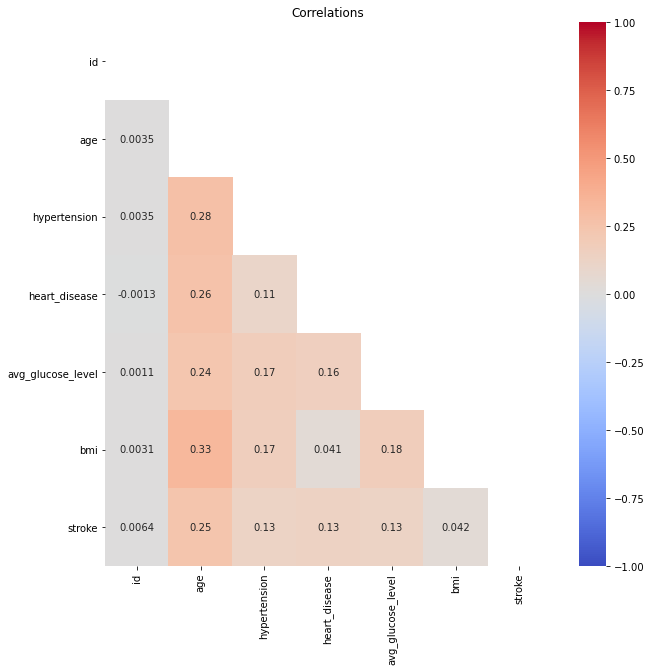

In [129]:
#NOTE: code tutorial for diaganol heatmap taken from https://heartbeat.fritz.ai/seaborn-heatmaps-13-ways-to-customize-correlation-matrix-visualizations-f1c49c816f07
matrix = np.triu(hd.corr())
fig, ax = plt.subplots(figsize=(10,10)) 
plt.title("Correlations")
sns.heatmap(hd.corr(), annot = True, mask=matrix, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', ax=ax)

Meaningful positive correlations between ageXstroke, hypertensionXstroke, heart_diseaseXstroke. Small + correlation between bmiXstroke. Id should be dropped.

# 2. Data Pipeline

In [130]:
#Drop id as it is arbitrary and only used to help store/catalog the input data
hd = hd.drop('id', axis=1)
hd.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [131]:
#what features do we need to impute due to nan values
hd.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [132]:
#bmi is only missing ~4% of its values
hd.isnull().sum()['bmi']/hd['bmi'].size
#impute with median to avoid outlier bmi from biasing

0.03933463796477495

In [133]:
hd['gender'].value_counts()
#there's only one other gender in the entire dataset, should I just ignore the 'other' values

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [134]:
hd['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

imputation --> augmentation --> scaling
split -> balance training, do not balance test

Feature Augmentation:

    weight_glucose = avg_glucose_level * bmi //if overweight and high blood sugar, correlated with diabetes and stroke
    
    hypertension_heart_disease = hyper_tension*heart_disease //as both are boolean, result is also boolean
    

Numerical features:

    age, avg_glucose_level, bmi, weight_glucose --> numerical scaler
    
    
Categorical features:

    gender, ever_married, residence_type, smoking_status --> lable encoding (females more likely for stroke, and only one 'other' gender in dataset
    hypertension, heart_disease, hypertension_heart_disease --> leave as is
    work_type --> OHE
    

In [135]:
#impute BMI with median
missing_col = ['bmi']
for i in missing_col:
    hd.loc[hd.loc[:, i].isnull(), i] = hd.loc[:,i].median()
hd['bmi'].isnull().sum()

0

In [136]:
#augment features
hd['weight_glucose'] = hd['avg_glucose_level'] * hd['bmi']
hd['hypertension_heart_disease'] = hd['hypertension'] * hd['heart_disease']
hd.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,weight_glucose,hypertension_heart_disease
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,8370.054,0
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1,5682.101,0
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,3442.400,0
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,5890.312,0
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,4178.880,0


In [137]:
numerical_features = ['age', 'avg_glucose_level', 'bmi', 'weight_glucose']
cat_features_ohe = ['work_type' ]
cat_features_le = ['gender', 'ever_married', 'Residence_type', 'smoking_status' , 'hypertension', 'heart_disease','hypertension_heart_disease']
#leave the rest as is

In [138]:
#label encode some cat features
from sklearn.preprocessing import OrdinalEncoder
for i in cat_features_le:
    ord_enc = OrdinalEncoder()
    hd[i] = ord_enc.fit_transform(hd[[i]])
hd.head()
    

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,weight_glucose,hypertension_heart_disease
0,1.0,67.0,0.0,1.0,1.0,Private,1.0,228.69,36.6,1.0,1,8370.054,0.0
1,0.0,61.0,0.0,0.0,1.0,Self-employed,0.0,202.21,28.1,2.0,1,5682.101,0.0
2,1.0,80.0,0.0,1.0,1.0,Private,0.0,105.92,32.5,2.0,1,3442.400,0.0
3,0.0,49.0,0.0,0.0,1.0,Private,1.0,171.23,34.4,3.0,1,5890.312,0.0
4,0.0,79.0,1.0,0.0,1.0,Self-employed,0.0,174.12,24.0,2.0,1,4178.880,0.0


In [139]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import preprocessing

In [140]:
#scale numerical features and one hot encode the rest of categorical vars

hd_features = hd.drop('stroke', axis=1)
hd_label = hd['stroke']



num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat_ohe", OneHotEncoder(), cat_features_ohe),
    ('nothing', 'passthrough' , cat_features_le)
])

hd_features.shape

(5110, 12)

In [141]:
#finish data pipeline
hd_prepared_unbalanced = full_pipeline.fit_transform(hd_features)
hd_prepared_unbalanced[1]

array([ 0.78607007,  2.12155854, -0.09898092,  1.42650907,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  2.        ,  0.        ,  0.        ,
        0.        ])

In [142]:
hd_prepared_unbalanced.shape

(5110, 16)

# 3. Basic Logistic Regression

In [143]:
#split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(hd_prepared_unbalanced, hd_label, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(4088, 16) (4088,)
(1022, 16) (1022,)


In [144]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(X_train, y_train)
predicted = log_reg.predict(X_test)
score = log_reg.predict_proba(X_test)[:,1]
log_reg_preds = predicted

In [145]:
print(f"Accuracy: {metrics.accuracy_score(y_test, log_reg_preds)}")
print(f"Precision: {metrics.precision_score(y_test, log_reg_preds)}")
print(f"Recall: {metrics.recall_score(y_test, log_reg_preds)}")
print(f"F1 Score: {metrics.f1_score(y_test, log_reg_preds)}")

###issue with unbalanced data, predicts everything as no stroke

Accuracy: 0.9422700587084148
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


C:\Users\dyera\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [146]:
hd_unbalanced = pd.concat([pd.DataFrame(hd_prepared_unbalanced), pd.DataFrame(hd_label)], axis=1)
hd_unbalanced.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,stroke
0,1.051434,2.706375,1.005086,2.924147,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1
1,0.786070,2.121559,-0.098981,1.426509,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1
2,1.626390,-0.005028,0.472536,0.178622,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2.0,0.0,1.0,0.0,1
3,0.255342,1.437358,0.719327,1.542517,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,1
4,1.582163,1.501184,-0.631531,0.588964,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,1


In [147]:
#seems like the model gets a very low mse rate as it is heavily biased towards no stroke and never predicts > 0.5 for stroke
#to fix this, I will balance the dataset

#code taken from https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb
from imblearn import under_sampling 
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE

# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
#oversampled_trainX, oversampled_trainY = sm.fit_resample(hd_unbalanced.drop('stroke', axis=1), hd_unbalanced['stroke'])
oversampled_trainX, oversampled_trainY = sm.fit_resample(X_train, y_train)
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)

In [148]:
log_reg = LogisticRegression(solver='liblinear')
log_reg.fit(oversampled_trainX, oversampled_trainY)
predicted = log_reg.predict(X_test)
score = log_reg.predict_proba(X_test)[:,1]
log_reg_preds = predicted
print(f"Accuracy: {metrics.accuracy_score(y_test, log_reg_preds)}")
print(f"Precision: {metrics.precision_score(y_test, log_reg_preds)}")
print(f"Recall: {metrics.recall_score(y_test, log_reg_preds)}")
print(f"F1 Score: {metrics.f1_score(y_test, log_reg_preds)}")

Accuracy: 0.738747553816047
Precision: 0.15562913907284767
Recall: 0.7966101694915254
F1 Score: 0.260387811634349


In [149]:
##statistical modeling for feature selection
import statsmodels.api as sm

# build the OLS model (ordinary least squares) from the training data
stats = sm.OLS(hd_label, hd_prepared_unbalanced)

# do the fit and save regression info (parameters, etc) in results_stats
results_stats = stats.fit()

In [150]:
print(results_stats.summary())

                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     31.50
Date:                Mon, 31 May 2021   Prob (F-statistic):           6.51e-87
Time:                        21:44:27   Log-Likelihood:                 823.41
No. Observations:                5110   AIC:                            -1615.
Df Residuals:                    5094   BIC:                            -1510.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0700      0.005     14.406      0.0

#  4. Principal Component Analysis (PCA)

In [151]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=6)
hd_unbalanced_label = hd_unbalanced['stroke']
hd_unbalanced_features = hd_unbalanced.drop('stroke', axis=1)
hd_pca = pca.fit_transform(hd_unbalanced_features)

In [152]:
hd_pca.shape

(5110, 6)

In [153]:
hd_pca

array([[ 3.75652956,  2.03862158, -0.0156282 , -0.36403933, -0.47095928,
        -0.45024525],
       [ 2.28571697,  0.80695305, -0.81279654, -1.09693869,  0.62511791,
         0.4788159 ],
       [ 1.22520312, -1.03201303,  0.59187467, -0.61589837, -0.47323799,
         0.58980588],
       ...,
       [-0.23491173, -0.74796311, -0.15499294,  0.31877295,  0.79487574,
         0.51422793],
       [ 0.89707368,  0.99563627, -0.23080413, -0.79972333, -0.69142489,
         0.52811049],
       [-0.96920177,  0.51329231,  1.0900334 , -0.37968008,  0.48477922,
        -0.52462224]])

In [154]:
#shrunk from 16->6 features

# 5. Ensemble Method - bagging

In [155]:
X_train, X_test, y_train, y_test = train_test_split(hd_pca, hd_unbalanced_label, test_size=0.2)

In [156]:
# Resample the minority class. You can change the strategy to 'auto' if you are not sure.
sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_resample(X_train, y_train)
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)

In [157]:
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier

In [159]:
bc = BaggingClassifier(base_estimator=DecisionTreeClassifier(), random_state=0)
bc.fit(oversampled_trainX, oversampled_trainY)
predictions = bc.predict(X_test)
log_reg_preds = predictions
print(f"Accuracy: {metrics.accuracy_score(y_test, log_reg_preds)}")
print(f"Precision: {metrics.precision_score(y_test, log_reg_preds)}")
print(f"Recall: {metrics.recall_score(y_test, log_reg_preds)}")
print(f"F1 Score: {metrics.f1_score(y_test, log_reg_preds)}")

Accuracy: 0.8874755381604696
Precision: 0.1375
Recall: 0.19298245614035087
F1 Score: 0.16058394160583941


In [160]:
bc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),replacement=True, sampling_strategy='auto', random_state=0)
bc.fit(oversampled_trainX, oversampled_trainY)
predictions = bc.predict(X_test)
log_reg_preds = predictions
print(f"Accuracy: {metrics.accuracy_score(y_test, log_reg_preds)}")
print(f"Precision: {metrics.precision_score(y_test, log_reg_preds)}")
print(f"Recall: {metrics.recall_score(y_test, log_reg_preds)}")
print(f"F1 Score: {metrics.f1_score(y_test, log_reg_preds)}")

Accuracy: 0.8796477495107632
Precision: 0.13333333333333333
Recall: 0.21052631578947367
F1 Score: 0.163265306122449


# 6. Neural Net Classifier

In [161]:
from sklearn.neural_network import MLPClassifier

In [190]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1, max_iter=5000)
clf.fit(oversampled_trainX, oversampled_trainY)
predictions = clf.predict(X_test)
log_reg_preds = predictions
print(f"Accuracy: {metrics.accuracy_score(y_test, log_reg_preds)}")
print(f"Precision: {metrics.precision_score(y_test, log_reg_preds)}")
print(f"Recall: {metrics.recall_score(y_test, log_reg_preds)}")
print(f"F1 Score: {metrics.f1_score(y_test, log_reg_preds)}")

Accuracy: 0.7338551859099804
Precision: 0.14285714285714285
Recall: 0.7543859649122807
F1 Score: 0.2402234636871508


In [191]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(2, 2), random_state=1, max_iter=5000)
clf.fit(oversampled_trainX, oversampled_trainY)
predictions = clf.predict(X_test)
log_reg_preds = predictions
print(f"Accuracy: {metrics.accuracy_score(y_test, log_reg_preds)}")
print(f"Precision: {metrics.precision_score(y_test, log_reg_preds)}")
print(f"Recall: {metrics.recall_score(y_test, log_reg_preds)}")
print(f"F1 Score: {metrics.f1_score(y_test, log_reg_preds)}")

Accuracy: 0.7113502935420744
Precision: 0.14156626506024098
Recall: 0.8245614035087719
F1 Score: 0.24164524421593833


In [192]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-3, hidden_layer_sizes=(5, 2), random_state=1, max_iter=5000)
clf.fit(oversampled_trainX, oversampled_trainY)
predictions = clf.predict(X_test)
log_reg_preds = predictions
print(f"Accuracy: {metrics.accuracy_score(y_test, log_reg_preds)}")
print(f"Precision: {metrics.precision_score(y_test, log_reg_preds)}")
print(f"Recall: {metrics.recall_score(y_test, log_reg_preds)}")
print(f"F1 Score: {metrics.f1_score(y_test, log_reg_preds)}")

Accuracy: 0.7074363992172211
Precision: 0.12422360248447205
Recall: 0.7017543859649122
F1 Score: 0.21108179419525064


In [193]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(2, 2), random_state=1, max_iter=5000)
clf.fit(oversampled_trainX, oversampled_trainY)
predictions = clf.predict(X_test)
log_reg_preds = predictions
print(f"Accuracy: {metrics.accuracy_score(y_test, log_reg_preds)}")
print(f"Precision: {metrics.precision_score(y_test, log_reg_preds)}")
print(f"Recall: {metrics.recall_score(y_test, log_reg_preds)}")
print(f"F1 Score: {metrics.f1_score(y_test, log_reg_preds)}")

Accuracy: 0.7113502935420744
Precision: 0.14156626506024098
Recall: 0.8245614035087719
F1 Score: 0.24164524421593833


In [189]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(2, 2), random_state=1, max_iter=5000)
clf.fit(oversampled_trainX, oversampled_trainY)
predictions = clf.predict(X_test)
log_reg_preds = predictions
print(f"Accuracy: {metrics.accuracy_score(y_test, log_reg_preds)}")
print(f"Precision: {metrics.precision_score(y_test, log_reg_preds)}")
print(f"Recall: {metrics.recall_score(y_test, log_reg_preds)}")
print(f"F1 Score: {metrics.f1_score(y_test, log_reg_preds)}")

Accuracy: 0.7103718199608611
Precision: 0.14114114114114115
Recall: 0.8245614035087719
F1 Score: 0.24102564102564106


In [188]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-9, hidden_layer_sizes=(2, 8), random_state=1, max_iter=5000)
clf.fit(oversampled_trainX, oversampled_trainY)
predictions = clf.predict(X_test)
log_reg_preds = predictions
print(f"Accuracy: {metrics.accuracy_score(y_test, log_reg_preds)}")
print(f"Precision: {metrics.precision_score(y_test, log_reg_preds)}")
print(f"Recall: {metrics.recall_score(y_test, log_reg_preds)}")
print(f"F1 Score: {metrics.f1_score(y_test, log_reg_preds)}")

Accuracy: 0.6868884540117417
Precision: 0.13774104683195593
Recall: 0.8771929824561403
F1 Score: 0.2380952380952381


after playing with the parameters, my best recall occurred with
alpha = 1e-9
layers = 2x8

# 7. Cross Validation

In [183]:
from sklearn.model_selection import KFold
from sklearn import model_selection

In [195]:
kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True) 

model_kfold = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),replacement=True, sampling_strategy='auto', random_state=0)

results_kfold = model_selection.cross_val_score(model_kfold, hd_unbalanced_features, hd_unbalanced_label, cv=kfold)

print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

Accuracy: 79.84%


In [196]:
kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True) 

model_kfold = MLPClassifier(solver='lbfgs', alpha=1e-2, hidden_layer_sizes=(2, 2), random_state=1, max_iter=5000)

results_kfold = model_selection.cross_val_score(model_kfold, hd_unbalanced_features, hd_unbalanced_label, cv=kfold)

print("Accuracy: %.2f%%" % (results_kfold.mean()*100.0)) 

Accuracy: 95.13%


# 8. Best Model

In [203]:
X_train, X_test, y_train, y_test = train_test_split(hd_pca, hd_unbalanced_label, test_size=0.2)

sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_resample(X_train, y_train)
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)

In [204]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-9, hidden_layer_sizes=(2, 8), random_state=1, max_iter=5000)
clf.fit(oversampled_trainX, oversampled_trainY)
predictions = clf.predict(X_test)
log_reg_preds = predictions
print(f"Accuracy: {metrics.accuracy_score(y_test, log_reg_preds)}")
print(f"Precision: {metrics.precision_score(y_test, log_reg_preds)}")
print(f"Recall: {metrics.recall_score(y_test, log_reg_preds)}")
print(f"F1 Score: {metrics.f1_score(y_test, log_reg_preds)}")

Accuracy: 0.7367906066536204
Precision: 0.11301369863013698
Recall: 0.7674418604651163
F1 Score: 0.19701492537313434


In [205]:
X_train, X_test, y_train, y_test = train_test_split(hd_unbalanced_features, hd_unbalanced_label, test_size=0.2)

sm = SMOTE(sampling_strategy='minority', random_state=7)

# Fit the model to generate the data.
oversampled_trainX, oversampled_trainY = sm.fit_resample(X_train, y_train)
oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)

In [207]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-9, hidden_layer_sizes=(2, 9), random_state=1, max_iter=5000)
clf.fit(oversampled_trainX, oversampled_trainY)
predictions = clf.predict(X_test)
log_reg_preds = predictions
print(f"Accuracy: {metrics.accuracy_score(y_test, log_reg_preds)}")
print(f"Precision: {metrics.precision_score(y_test, log_reg_preds)}")
print(f"Recall: {metrics.recall_score(y_test, log_reg_preds)}")
print(f"F1 Score: {metrics.f1_score(y_test, log_reg_preds)}")

Accuracy: 0.7407045009784736
Precision: 0.1390728476821192
Recall: 0.8936170212765957
F1 Score: 0.24068767908309452


My best model, with a priority on Recall, would be a mlp classifier using the PCA reduced feature space along with SMOTE minority balancing to balance ONLY the training data and NOT the test data